# MAT281 - Laboratorio N°11

<a id='p1'></a>
## I.- Problema 01

Lista de actos delictivos registrados por el Service de police de la Ville de Montréal (SPVM).


<img src="http://henriquecapriles.com/wp-content/uploads/2017/02/femina_detenida-1080x675.jpg" width="480" height="360" align="center"/>

El conjunto de datos en estudio `interventionscitoyendo.csv` corresponde a  todos los delitos entre 2015 y agosto de 2020 en Montreal. Cada delito está asociado en grandes categorías, y hay información sobre la ubicación, el momento del día, etc.

> **Nota**: Para más información seguir el siguiente el [link](https://donnees.montreal.ca/ville-de-montreal/actes-criminels).

In [2]:
# librerias 

import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from metrics_regression import *


# graficos incrustados
plt.style.use('fivethirtyeight')
%matplotlib inline

# parametros esteticos de seaborn
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (12, 4)})

In [3]:
# read data

validate_categorie = [
  'Introduction', 'Méfait','Vol dans / sur véhicule à moteur', 'Vol de véhicule à moteur',
]

df = pd.read_csv(os.path.join("data","interventionscitoyendo.csv"), sep=",", encoding='latin-1')
df.columns = df.columns.str.lower()
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

df = df.loc[lambda x: x['categorie'].isin(validate_categorie)]
df = df.sort_values(['categorie','date'])
df.head()

,categorie,date,quart,pdq,x,y,longitude,latitude
3462,Introduction,2015-01-01,jour,42.0,297210.375006,5.050179e+06,-73.597273,45.591480
8370,Introduction,2015-01-01,soir,13.0,297145.531007,5.032845e+06,-73.597834,45.435501
11968,Introduction,2015-01-01,nuit,8.0,289215.072000,5.036423e+06,-73.699308,45.467564
12763,Introduction,2015-01-01,soir,27.0,293203.472992,5.045436e+06,-73.648516,45.548740
13686,Introduction,2015-01-01,soir,44.0,298915.433995,5.046912e+06,-73.575381,45.562090


Como tenemos muchos datos por categoría a nivel de día, agruparemos a nivel de **semanas** y separaremos cada serie temporal.

In [4]:
cols = ['date','pdq']
y_s1 = df.loc[lambda x: x.categorie == validate_categorie[0] ][cols].set_index('date').resample('W').mean()
y_s2 = df.loc[lambda x: x.categorie == validate_categorie[1] ][cols].set_index('date').resample('W').mean()
y_s3 = df.loc[lambda x: x.categorie == validate_categorie[2] ][cols].set_index('date').resample('W').mean()
y_s4 = df.loc[lambda x: x.categorie == validate_categorie[3] ][cols].set_index('date').resample('W').mean()

In [33]:
y_s1

,pdq
date,
2015-01-04,23.337079
2015-01-11,25.687861
2015-01-18,26.547170
2015-01-25,27.267016
2015-02-01,28.213018
...,...
2021-10-31,24.603306
2021-11-07,24.494949
2021-11-14,24.160000


El objetivo de este laboratorio es poder realizar un análisis completo del conjunto de datos en estudio, para eso debe responder las siguientes preguntas:

1. Realizar un gráfico para cada serie temporal $y\_{si}, i =1,2,3,4$.


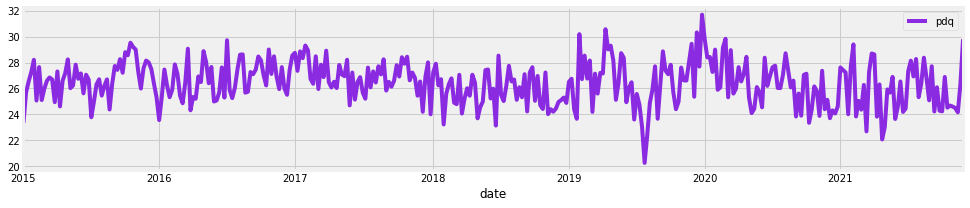

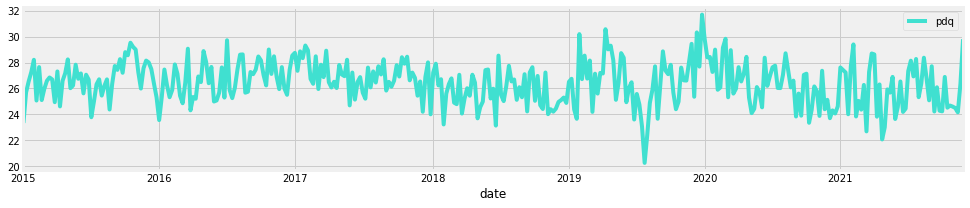

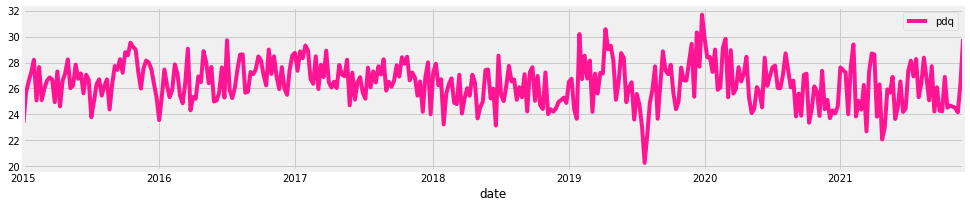

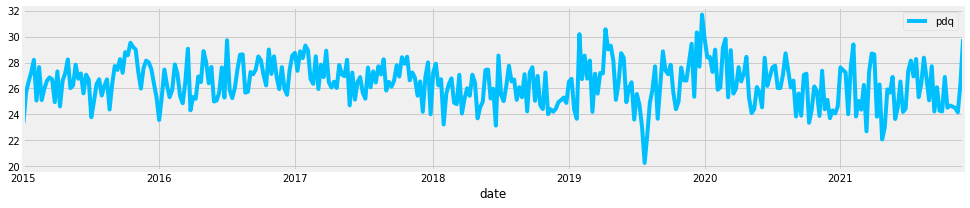

In [30]:
y_s1.plot(figsize=(15,3),color='blueviolet')
y_s1.plot(figsize=(15,3),color='turquoise')
y_s1.plot(figsize=(15,3),color='deeppink')
y_s1.plot(figsize=(15,3),color='deepskyblue')
plt.show()

2. Escoger alguna serie temporal $y\_{si}, i =1,2,3,4$. Luego:

* Realice un análisis exploratorio de la serie temporal escogida
* Aplicar el modelo de pronóstico $SARIMA(p,d,q)x(P,D,Q,S)$, probando varias configuraciones de los hiperparámetros. Encuentre la mejor configuración. Concluya.
* Para el mejor modelo encontrado, verificar si el residuo corresponde a un ruido blanco.

> **Hint**: Tome como `target_date` =  '2021-01-01'. Recuerde considerar que su columna de valores se llama `pdq`.


# Análisis exploratorio

In [45]:
def resumen(df,cols):
    pd_s=df[cols]
    u=pd_s.unique()
    v=pd_s[pd_s.isna()]
    df_info = pd.DataFrame({
        'columna': [cols],
        'unicos': [len(u)],
        'vacios': [len(v)]
    })
    return df_info

In [46]:
f=[]
for col in y_s1:
    aux=resumen(y_s1,col)
    f.append(aux)
df_info = pd.concat(f).reset_index(drop=True)
df_info['% vacios'] = df_info['vacios']/len(y_s1)
df_info

,columna,unicos,vacios,% vacios
0,pdq,359,0,0.0


# Modelo SARIMA

In [49]:
# creando clase SarimaModels

class SarimaModels:
    def __init__(self,params):

        self.params = params
        
        
    @property
    def name_model(self):
        return f"SARIMA_{self.params[0]}X{self.params[1]}".replace(' ','')
    
    @staticmethod
    def test_train_model(y,date):
        mask_ds = y.index < date

        y_train = y[mask_ds]
        y_test = y[~mask_ds]        
        
        return y_train, y_test
    
    def fit_model(self,y,date):
        y_train, y_test = self.test_train_model(y,date )
        model = SARIMAX(y_train,
                        order=self.params[0],
                        seasonal_order=self.params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        
        model_fit = model.fit(disp=0)

        return model_fit
    
    def df_testig(self,y,date):
        y_train, y_test = self.test_train_model(y,date )
        model = SARIMAX(y_train,
                        order=self.params[0],
                        seasonal_order=self.params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        
        model_fit = model.fit(disp=0)
        
        start_index = y_test.index.min()
        end_index = y_test.index.max()

        preds = model_fit.get_prediction(start=start_index,end=end_index, dynamic=False)
        df_temp = pd.DataFrame(
            {
                'y':y_test['pdq'],
                'yhat': preds.predicted_mean
            }
        )
        
        return df_temp
    
    def metrics(self,y,date):
        df_temp = self.df_testig(y,date)
        df_metrics = summary_metrics(df_temp)
        df_metrics['model'] = self.name_model
        
        return df_metrics

# definir parametros 

import itertools

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

params = list(itertools.product(pdq,seasonal_pdq))
target_date = '2021-01-01'

In [51]:
frames = []
for param in params:
    try:
        sarima_model = SarimaModels(param)
        df_metrics = sarima_model.metrics(y_s1,target_date)
        frames.append(df_metrics)
    except:
        pass

C:\Users\javie\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [78]:
df_metrics_result = pd.concat(frames)
df_metrics_result.sort_values(['mae','mse','rmse','mape','maape','wmape','mmape','smape'])

,mae,mse,rmse,mape,maape,wmape,mmape,smape,model
0,1.5876,3.4224,1.8500,0.0622,0.0620,0.0614,0.0599,0.0614,"SARIMA_(0,0,0)X(1,0,1,12)"
0,1.5934,3.4304,1.8521,0.0624,0.0622,0.0616,0.0600,0.0616,"SARIMA_(0,0,1)X(1,0,1,12)"
0,1.6021,3.4537,1.8584,0.0627,0.0625,0.0619,0.0603,0.0619,"SARIMA_(1,0,0)X(1,0,1,12)"
0,1.6444,3.7832,1.9451,0.0654,0.0651,0.0635,0.0629,0.0635,"SARIMA_(0,0,0)X(0,1,1,12)"
0,1.6444,3.7833,1.9451,0.0654,0.0651,0.0635,0.0629,0.0635,"SARIMA_(0,0,0)X(1,1,1,12)"
...,...,...,...,...,...,...,...,...,...
0,7.8111,73.7850,8.5898,0.2988,0.2862,0.3019,0.2877,0.3654,"SARIMA_(1,1,0)X(0,1,0,12)"
0,22.8403,550.3450,23.4594,0.8845,0.7122,0.8827,0.8514,1.6822,"SARIMA_(0,0,1)X(0,0,1,12)"
0,23.0209,560.5370,23.6757,0.8899,0.7147,0.8896,0.8567,1.7030,"SARIMA_(0,0,0)X(0,0,1,12)"
0,25.5633,660.3857,25.6980,0.9886,0.7779,0.9879,0.9517,1.9706,"SARIMA_(0,0,1)X(0,0,0,12)"


In [64]:
parami = [(0,0,0),(1,0,1,12)]
sarima_model =  SarimaModels(parami)
model_fit = sarima_model.fit_model(y_s1,target_date)
best_model = sarima_model.df_testig(y_s1,target_date)
best_model.head()

,y,yhat
2021-01-03,27.622449,26.158298
2021-01-10,27.425532,25.926903
2021-01-17,27.235294,26.083721
2021-01-24,24.012658,26.308888
2021-01-31,27.716418,26.074931


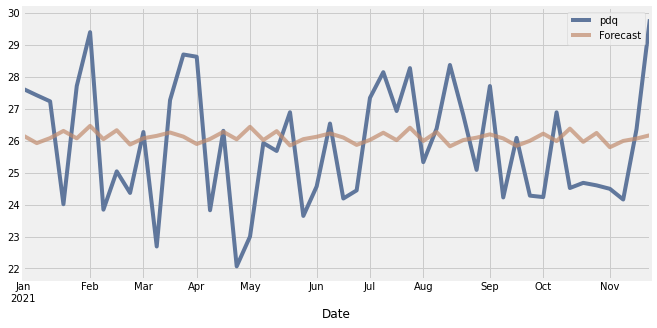

In [68]:
preds = best_model['yhat']
ax = y_s1['2021':].plot(label='observed')
preds.plot(ax=ax, label='Forecast', alpha=.7, figsize=(10, 5))
ax.set_xlabel('Date')
plt.legend()
plt.show()

__Conclusión:__ El estudio observa que el mejor modelo es `SARIMA(0,0,0)x(1,0,1,12)`, pero notamos que no se acerca absolutamente en nada a nuestra serie temporal

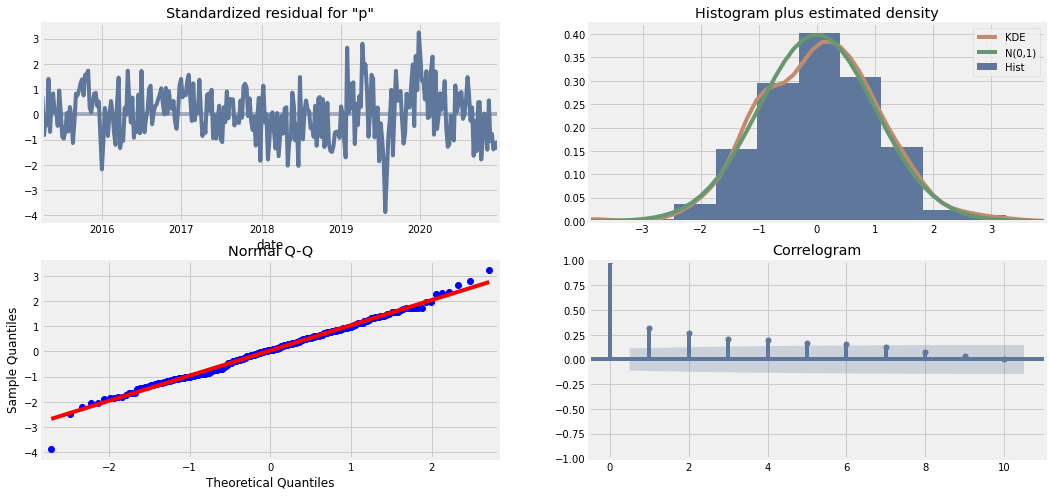

In [79]:
model_fit.plot_diagnostics(figsize=(16, 8))
plt.show()

__Respuesta:__ Notamos que el error asociado es un ruido blanco